### Event extraction from disaster tweets

In [1]:
#importing necessary libraries
import re
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

### Word emebeddings:
- Using spacy en_core_web model(larger version) to get the wrod embeddings.

In [2]:
!python -m spacy download en_core_web_lg

                                              0.0/587.7 MB ? eta -:--:--
                                              0.1/587.7 MB 1.3 MB/s eta 0:07:30
                                              0.1/587.7 MB 1.7 MB/s eta 0:05:45
                                              0.3/587.7 MB 2.2 MB/s eta 0:04:26
                                              0.4/587.7 MB 2.3 MB/s eta 0:04:18
                                              0.5/587.7 MB 2.2 MB/s eta 0:04:28
                                              0.6/587.7 MB 2.1 MB/s eta 0:04:38
                                              0.6/587.7 MB 2.0 MB/s eta 0:04:59
                                              0.7/587.7 MB 1.8 MB/s eta 0:05:18
                                              0.8/587.7 MB 1.8 MB/s eta 0:05:20
                                              0.8/587.7 MB 1.7 MB/s eta 0:05:42
                                              0.9/587.7 MB 1.7 MB/s eta 0:05:48
                                              1

In [3]:
nlp = spacy.load('en_core_web_lg')

### Dataset:
- The dataset I have taken is from kaggle.[link](https://www.kaggle.com/datasets/vstepanenko/disaster-tweets)
- The data is originally for detecting if the tweet is real or fake hence the target values.
- I have removed the fake tweets(target = 0)

In [4]:
df = pd.read_csv('tweets.csv')

In [5]:
df

id  keyword                 location  \
0          0   ablaze                      NaN   
1          1   ablaze                      NaN   
2          2   ablaze            New York City   
3          3   ablaze           Morgantown, WV   
4          4   ablaze                      NaN   
...      ...      ...                      ...   
11365  11365  wrecked  Blue State in a red sea   
11366  11366  wrecked               arohaonces   
11367  11367  wrecked                       🇵🇭   
11368  11368  wrecked           auroraborealis   
11369  11369  wrecked                      NaN   

                                                    text  target  
0      Communal violence in Bhainsa, Telangana. "Ston...       1  
1      Telangana: Section 144 has been imposed in Bha...       1  
2      Arsonist sets cars ablaze at dealership https:...       1  
3      Arsonist sets cars ablaze at dealership https:...       1  
4      "Lord Jesus, your love brings freedom and pard...       0  
...                                                  ...     ...  
11365  Media should have warned us well in advance. T...       0  
11366  i feel directly attacked 💀 i consider moonbin ...       0  
11367  i feel directly attacked 💀 i consider moonbin ...       0  
11368  ok who remember "outcast" nd the "dora" au?? T...       0  
11369     Jake Corway wrecked while running 14th at IRP.       1  

[11370 rows x 5 columns]

In [6]:
df['target'].value_counts()

0    9256
1    2114
Name: target, dtype: int64

In [7]:
#removing fake tweets
df = df.drop(df[df.target == 0].iloc[:9256].index)
df

id  keyword         location  \
0          0   ablaze              NaN   
1          1   ablaze              NaN   
2          2   ablaze    New York City   
3          3   ablaze   Morgantown, WV   
6          6   ablaze  London, England   
...      ...      ...              ...   
11338  11338  wrecked          Puchong   
11354  11354  wrecked              NaN   
11355  11355  wrecked           Recife   
11359  11359  wrecked   Washington, DC   
11369  11369  wrecked              NaN   

                                                    text  target  
0      Communal violence in Bhainsa, Telangana. "Ston...       1  
1      Telangana: Section 144 has been imposed in Bha...       1  
2      Arsonist sets cars ablaze at dealership https:...       1  
3      Arsonist sets cars ablaze at dealership https:...       1  
6      Several houses have been set ablaze in Ngemsib...       1  
...                                                  ...     ...  
11338  Kesian ular. We have wrecked their natural hab...       1  
11354  Yeah, proper Liverpool fans wrecked Man City’s...       1  
11355  "Trump and Sisi 'rejected foreign exploitation...       1  
11359  "Trump and Sisi 'rejected foreign exploitation...       1  
11369     Jake Corway wrecked while running 14th at IRP.       1  

[2114 rows x 5 columns]

In [8]:
def preprocess(text):
    #converting the tweets into lowercase
    text = text.lower()
    #removing links
    text = re.sub(r'http\S+', '', text)
    #removing special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    doc = nlp(text)
    #removing stop words
    tokens = [token.text for token in doc if not token.is_stop]
    
    #lemmatize the tokens
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    text = ' '.join(lemmas)
    
    return text

In [9]:
df['pre_text'] = df['text'].apply(preprocess)

In [10]:
df

id  keyword         location  \
0          0   ablaze              NaN   
1          1   ablaze              NaN   
2          2   ablaze    New York City   
3          3   ablaze   Morgantown, WV   
6          6   ablaze  London, England   
...      ...      ...              ...   
11338  11338  wrecked          Puchong   
11354  11354  wrecked              NaN   
11355  11355  wrecked           Recife   
11359  11359  wrecked   Washington, DC   
11369  11369  wrecked              NaN   

                                                    text  target  \
0      Communal violence in Bhainsa, Telangana. "Ston...       1   
1      Telangana: Section 144 has been imposed in Bha...       1   
2      Arsonist sets cars ablaze at dealership https:...       1   
3      Arsonist sets cars ablaze at dealership https:...       1   
6      Several houses have been set ablaze in Ngemsib...       1   
...                                                  ...     ...   
11338  Kesian ular. We have wrecked their natural hab...       1   
11354  Yeah, proper Liverpool fans wrecked Man City’s...       1   
11355  "Trump and Sisi 'rejected foreign exploitation...       1   
11359  "Trump and Sisi 'rejected foreign exploitation...       1   
11369     Jake Corway wrecked while running 14th at IRP.       1   

                                                pre_text  
0      communal violence bhainsa telangana stone pelt...  
1      telangana section 144 impose bhainsa january 1...  
2                     arsonist set car ablaze dealership  
3                   arsonist set car ablaze dealership    
6      house set ablaze ngemsibaa village oku sub div...  
...                                                  ...  
11338                  kesian ular wreck natural habitat  
11354  yeah proper liverpool fan wreck man citys bus ...  
11355  trump sisi reject foreign exploitation agree p...  
11359  trump sisi reject foreign exploitation agree p...  
11369                     jake corway wreck run 14th irp  

[2114 rows x 6 columns]

**Named entity recognition**:
- We can use NER to try to get dates or location or events.

In [11]:
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [12]:
df['ner'] = df['pre_text'].apply(extract_entities)
df

id  keyword         location  \
0          0   ablaze              NaN   
1          1   ablaze              NaN   
2          2   ablaze    New York City   
3          3   ablaze   Morgantown, WV   
6          6   ablaze  London, England   
...      ...      ...              ...   
11338  11338  wrecked          Puchong   
11354  11354  wrecked              NaN   
11355  11355  wrecked           Recife   
11359  11359  wrecked   Washington, DC   
11369  11369  wrecked              NaN   

                                                    text  target  \
0      Communal violence in Bhainsa, Telangana. "Ston...       1   
1      Telangana: Section 144 has been imposed in Bha...       1   
2      Arsonist sets cars ablaze at dealership https:...       1   
3      Arsonist sets cars ablaze at dealership https:...       1   
6      Several houses have been set ablaze in Ngemsib...       1   
...                                                  ...     ...   
11338  Kesian ular. We have wrecked their natural hab...       1   
11354  Yeah, proper Liverpool fans wrecked Man City’s...       1   
11355  "Trump and Sisi 'rejected foreign exploitation...       1   
11359  "Trump and Sisi 'rejected foreign exploitation...       1   
11369     Jake Corway wrecked while running 14th at IRP.       1   

                                                pre_text  \
0      communal violence bhainsa telangana stone pelt...   
1      telangana section 144 impose bhainsa january 1...   
2                     arsonist set car ablaze dealership   
3                   arsonist set car ablaze dealership     
6      house set ablaze ngemsibaa village oku sub div...   
...                                                  ...   
11338                  kesian ular wreck natural habitat   
11354  yeah proper liverpool fan wreck man citys bus ...   
11355  trump sisi reject foreign exploitation agree p...   
11359  trump sisi reject foreign exploitation agree p...   
11369                     jake corway wreck run 14th irp   

                                                     ner  
0                                   [(house house, ORG)]  
1      [(telangana section, ORG), (january 13 15, DAT...  
2                                                     []  
3                                                     []  
6      [(house, ORG), (ngemsibaa village oku sub, FAC...  
...                                                  ...  
11338                                                 []  
11354                                 [(liverpool, GPE)]  
11355                             [(trump sisi, PERSON)]  
11359                             [(trump sisi, PERSON)]  
11369           [(jake corway, PERSON), (14th, ORDINAL)]  

[2114 rows x 7 columns]

In [13]:
#converting the tweets to vectors
sent_vecs = {}
docs = []

for data in tqdm(df.pre_text):
    doc = nlp(data)
    docs.append(doc)
    sent_vecs.update({data: doc.vector})

sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

100%|█████████████████████████████████████████████████| 2114/2114 [00:15<00:00, 139.93it/s]


In [14]:
vectors

[array([-1.5043017e+00, -1.0206577e-01, -2.0825293e+00,  4.3607342e-01,
         1.6640924e+00, -1.5269450e+00,  2.1476550e+00,  1.8095382e+00,
         4.9319413e-01,  1.4241050e+00,  3.0540617e+00,  8.4760338e-01,
        -2.5282633e+00,  2.4144583e+00,  2.5176165e-01, -3.3033749e-01,
         5.7401663e-01, -6.7617238e-02,  5.9763551e-01, -1.6109649e+00,
         1.6430420e+00, -2.7537736e-01,  6.0184729e-01,  8.4588312e-02,
         7.1181840e-01, -4.5763752e-01, -2.0362265e+00, -1.9405236e+00,
        -1.3774700e+00, -9.3052334e-01,  1.3000958e-01, -5.1665634e-01,
         7.4540251e-01, -2.8879802e+00, -6.2351745e-01, -7.8502417e-01,
         9.7890042e-02,  2.3756588e+00,  2.8707162e-01, -6.6633624e-01,
        -2.2227500e-01, -1.9844233e+00,  5.8592576e-01,  4.9277592e-01,
        -1.3181201e+00,  1.2132369e+00, -2.5618753e-01, -1.5623165e+00,
         4.7443197e-03,  9.8935015e-02,  6.4200856e-02,  2.4126899e+00,
        -9.6519150e-02, -2.9591610e+00, -9.2279989e-01,  9.32640

In [15]:
sentences

['communal violence bhainsa telangana stone pelt muslims house house vehicle set ablaze',
 'telangana section 144 impose bhainsa january 13 15 clash erupt group january 12 po',
 'arsonist set car ablaze dealership',
 'arsonist set car ablaze dealership  ',
 'house set ablaze ngemsibaa village oku sub division north west region cameroon',
 'asansol bjp office salanpur village set ablaze night bjp allege tmc incident police b',
 'image show havoc cause cameroon military torch house okuthe shameless military report',
 'hausa youths set area office apapaiganmu local council development area ablaze okada rider storm lg area office',
 'mamatabanerjee political violence amp vandalism continue unabated west bengal office asanol',
 'image show havoc cause cameroon military torch house okuthe shameless military',
 'cow today local factory sadly ablaze redjanuary2020',
 'french cameroun set house ablaze ndu roast young boy home target killing genocideinsou',
 'cameroon bir soldier 05012020 invade

### DBSCAN:
- DBSCAN can be used to cluster the tweets similar to each other.
- we don't need to specify the number of clusters. It figures out on its own.

In [16]:
x = np.array(vectors)

n_classes = {}

for i in tqdm(np.arange(0.001, 1, 0.002)):
    dbscan = DBSCAN(eps = i, min_samples=4, metric='cosine').fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

dbscan = DBSCAN(eps=0.08, min_samples=4, metric='cosine').fit(x)

100%|████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.47it/s]


In [17]:
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('num of clusters: ', n_clusters_)
print('num of noise points: ', n_noise_)

num of clusters:  18
num of noise points:  1841


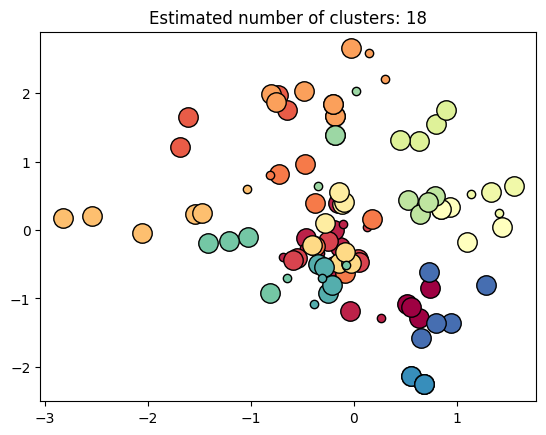

In [18]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        #col = [0, 0, 0, 1]
        continue

    class_member_mask = labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [24]:
one = []
two = []
print('labels --> freq')
one, two = np.unique(labels, return_counts=True)
for i in range(len(one)):
    print(f'{one[i]} ---> {two[i]}')

labels --> freq
-1 ---> 1841
0 ---> 4
1 ---> 12
2 ---> 6
3 ---> 4
4 ---> 7
5 ---> 10
6 ---> 6
7 ---> 4
8 ---> 4
9 ---> 5
10 ---> 4
11 ---> 4
12 ---> 4
13 ---> 4
14 ---> 6
15 ---> 6
16 ---> 5
17 ---> 5


In [20]:
results = pd.DataFrame({'label': dbscan.labels_, 'sent':sentences})
example_result = results[results.label == 1].sent.tolist()
event_df = df[df.pre_text.isin(example_result)][['pre_text', 'ner']]
event_df = event_df.dropna()

In [21]:
pd.options.display.max_colwidth = 200

### Extracted events:

In [22]:
event_df

pre_text  \
1302                             gardai seal scene body part find bag north dublin   
1308                              body part find bag moatview coolock north dublin   
1317               break underway apparent body part find bag coolock north dublin   
1323  body part find bag coolock north dublin investigation early stage gardai tre   
1332                                           human body part discover bag dublin   
1333                                        human body part find bag road dublin     
1337                                       bag contain human body part find dublin   
1339                garda investigation launch body part discover bag north dublin   
1345                               suspect body part discover plastic bag dublin     
1350                           human body part find bag outside house north dublin   
1355                                           human body part discover bag dublin   
1359   body part find bag coolock north dublin investigation early stage gardai ar   
1361                             gardai seal scene body part find bag north dublin   
1367                                       suspect body part discover bag dublin     

                                                    ner  
1302                     [(gardai, ORG), (dublin, GPE)]  
1308         [(bag moatview coolock north dublin, FAC)]  
1317          [(bag coolock north, ORG), (dublin, GPE)]  
1323   [(bag coolock north dublin, ORG), (gardai, ORG)]  
1332                                [(bag dublin, FAC)]  
1333                                                 []  
1337                                    [(dublin, GPE)]  
1339  [(garda investigation, ORG), (north dublin, GPE)]  
1345                           [(bag dublin  , PERSON)]  
1350                              [(north dublin, GPE)]  
1355                                [(bag dublin, FAC)]  
1359   [(bag coolock north dublin, ORG), (gardai, ORG)]  
1361                     [(gardai, ORG), (dublin, GPE)]  
1367                           [(bag dublin  , PERSON)]